In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

In [2]:
%matplotlib inline

In [3]:
import specsim.atmosphere
import specsim.simulator
import astropy.units as u
import astropy.table
from scipy import interpolate
from speclite import filters

In [4]:
gfilt = filters.load_filter('decam2014-g')

In [5]:
FILE_DIR='/global/homes/c/crockosi/brightsky/2018feb_mooncheck/parker/'

In [6]:
# Parker's get_continuum function
def get_continuum(atm_model, lower = 4600, upper = 4800):
    """Measures sky continuum level in sky spectrum created from specsim
    """
    sky = atm_model.surface_brightness.to(sky_unit)*area
    sky = sky.value
    wave = atm_model._wavelength.to(u.Angstrom).value
    idx = np.where((wave > lower)& (wave < upper))
    mean_sky_value = np.mean(sky[idx])
    
    return mean_sky_value

In [7]:
#Parker's get_sky_model
def get_sky_model(data_line):
    """ Defines DESI sky model taken from specsim.atmosphere
    """
    airmass = data_line['AIRMASS']
    moon_zenith = data_line['MOON_ZENITH']*u.deg
    moon_sep = data_line['MOON_SEP']*u.deg
    moon_phase = data_line['MPHASE']
    seeing50 = data_line['SEEING50']*u.arcsec
    
    moon = specsim.atmosphere.Moon(wavelength, moon_spectrum, extinction_coefficient,
            airmass, moon_zenith, moon_sep, moon_phase)
    
    seeing = dict(fwhm_ref=seeing50,
                  wlen_ref=6335*u.Angstrom,
                  moffat_beta=float(3.5))
    
    atmosphere = specsim.atmosphere.Atmosphere(
        wavelength, surface_brightness_dict, extinction_coefficient,
        'yes', 'dark', airmass, seeing, moon)
    
    return atmosphere

In [8]:
sky_unit = 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom * u.arcsec**2)
area = 1 * u.arcsec ** 2

In [9]:
DESIMODEL_DIR = (os.getenv('DESIMODEL'))

In [10]:
wavelength = np.linspace(3550, 9850, (9850-3550)*10)*u.Angstrom
#moon spectrum
moon_s = np.loadtxt(FILE_DIR + 'solarspec.txt')
moon_s = interpolate.interp1d(moon_s[:,1], moon_s[:,2])
moon_spectrum = moon_s(wavelength)* u.erg/ (u.cm**2 * u.s * u.Angstrom)

#extinction curve
ext_c = np.loadtxt(FILE_DIR + 'ZenithExtinction-KPNO.dat')
ext_c = interpolate.interp1d(ext_c[:,0], ext_c[:,1])
extinction_coefficient = ext_c(wavelength)

#surface brightness
# use DESIMODEL dark sky spectrum
surf_bright = np.loadtxt(DESIMODEL_DIR+'/data/spectra/spec-sky.dat')
surf_bright = interpolate.interp1d(surf_bright[:,0], surf_bright[:,1])
surface_brightness_dict = {'dark':surf_bright(wavelength)*sky_unit}

In [11]:
#Parker's load_data
def load_data(filen = FILE_DIR + 'good_data.fits'):
    """
    INPUT: files created in bright_moon_cont.py
    The following files can be loaded:
    bright_data.fits: when sky > 2.5*dark sky (defined as 2.78x10^17erg/s/cm2/A)
    dark_data.fits: Sun Alt < -18, Moon Alt < -18
    gray_data.fits: Moon Alt > 0, sky < 2.5*dark sky
    good_data.fits: All sky measurements on BOSS that are 'good'
    
    The files include required meta data and the measured continuum between 460-480nm
    
    OUTPUT: fits table with sky from 460-480nm from DESI sky model included
    """
    data = astropy.table.Table.read(filen)
    moon_zenith = 90-data['MOON_ALT']
    data['MOON_ZENITH'] = astropy.table.Column(moon_zenith.astype(np.float32), unit='deg')
    # Compute the pointing zenith angle in degrees.
    obs_zenith = 90 - data['ALT']
    data['OBS_ZENITH'] = astropy.table.Column(obs_zenith.astype(np.float32), unit='deg')

    mphase = np.arccos(2 * data['MOON_ILL'] - 1) / np.pi
    data['MPHASE'] = astropy.table.Column(mphase.astype(np.float32))
    moon_sep = data['MOON_SEP']
    
    cont_level = [get_continuum(get_sky_model(line)) for line in data]
    
    data['MODEL_SKY'] = astropy.table.Column(np.array(cont_level).astype(np.float32), unit=sky_unit)
    
    return data


In [12]:
bossdata = load_data(FILE_DIR+'/boss_cont_data.fits')

In [13]:
# no, this is wrong. The same spFuxCalib vector was used for all the flux calibrations, 
# that means all of the spectra were corrected using obserations at a SINGLE airmass.
# from David Kirkby: exposure #00139379 with X ~ 1.08
# back out the desisim extinction correction from the boss continumm measurements
#def unextinctbosscont(bossdata):
#    import specsim.simulator
#    import specsim.atmosphere
#    import astropy.units as u
#    sky_unit = 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom * u.arcsec**2)
#    simi=specsim.simulator.Simulator('desi')
#    # get the extinction coeff vector
#    ext_coeff = simi.atmosphere._extinction_coefficient
#    # wavelength range for continuum measurement
#    lower = 4600
#    upper = 4800
#    wave = simi.atmosphere.moon._wavelength.value
#    idx, = np.where((wave > lower)& (wave < upper))
#    # output vector of extincted continuum measurements
#    skyfix=np.zeros((len(bossdata)))
#    for i in range(len(bossdata)):
#        airmass = bossdata['AIRMASS'][i]
#        extinctionvec = 10 ** (-ext_coeff * airmass / 2.5)
#        ext_val = np.mean(extinctionvec[idx])
#        skyfix[i] = bossdata['SKY_VALUE'][i]*ext_val
#    return skyfix

In [14]:
#unextcont = unextinctbosscont(bossdata)

Back out the extinction correction at 1.08 airmass

In [15]:
airmass = 1.08
simi=specsim.simulator.Simulator('desi')
ext_coeff = simi.atmosphere._extinction_coefficient
lower = 4600
upper = 4800
wave = simi.atmosphere.moon._wavelength.value
idx, = np.where((wave > lower)& (wave < upper))
extinctionvec = 10 ** (-ext_coeff * airmass / 2.5)
ext_val = np.mean(extinctionvec[idx])

In [16]:
print(ext_val)

0.809967126545


In [17]:
unextcont = bossdata['SKY_VALUE']*ext_val

In [18]:
imoon, = np.where((bossdata['MOON_ALT'] > 0) & (bossdata['MOON_SEP'] > 50))

Ratio measured sky to model sky, 460 480 nm

In [19]:
skyratio = bossdata['SKY_VALUE']/bossdata['MODEL_SKY']

Now ratio of bossdata after applying desisim extinction to model sky, 460-480 nm

In [20]:
extskyratio = unextcont/bossdata['MODEL_SKY']

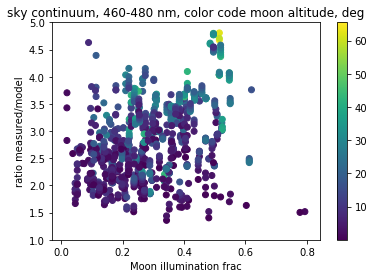

In [21]:
plt.scatter(bossdata['MOON_ILL'][imoon],skyratio[imoon],c=bossdata['MOON_ALT'][imoon])
plt.ylim(1,5)
plt.ylabel('ratio measured/model')
plt.xlabel('Moon illumination frac')
plt.title('sky continuum, 460-480 nm, color code moon altitude, deg')
plt.colorbar()

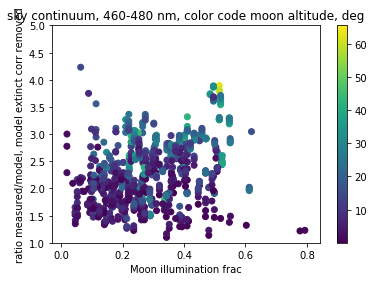

In [22]:
plt.scatter(bossdata['MOON_ILL'][imoon],extskyratio[imoon],c=bossdata['MOON_ALT'][imoon])
plt.ylim(1,5)
plt.ylabel('ratio measured/model, model extinct corr removed')
plt.xlabel('Moon illumination frac')
plt.title('sky continuum, 460-480 nm, color code moon altitude, deg')
plt.colorbar()

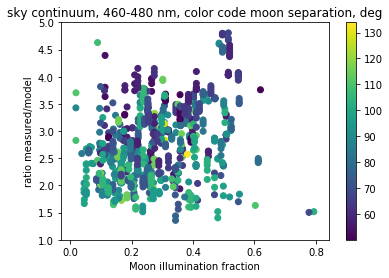

In [23]:
plt.scatter(bossdata['MOON_ILL'][imoon],skyratio[imoon],c=bossdata['MOON_SEP'][imoon])
plt.ylim(1,5)
plt.ylabel('ratio measured/model')
plt.xlabel('Moon illumination fraction')
plt.title('sky continuum, 460-480 nm, color code moon separation, deg')
plt.colorbar()

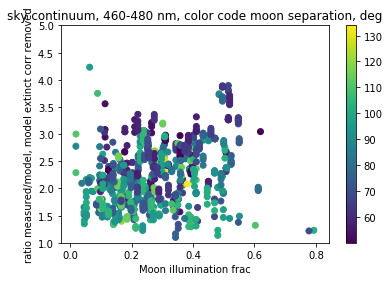

In [24]:
plt.scatter(bossdata['MOON_ILL'][imoon],extskyratio[imoon],c=bossdata['MOON_SEP'][imoon])
plt.ylim(1,5)
plt.ylabel('ratio measured/model, model extinct corr removed')
plt.xlabel('Moon illumination frac')
plt.title('sky continuum, 460-480 nm, color code moon separation, deg')
plt.colorbar()

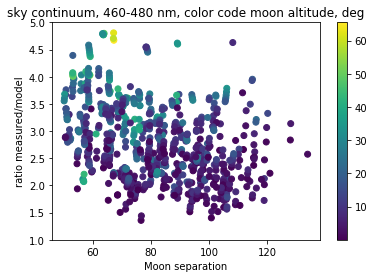

In [25]:
plt.scatter(bossdata['MOON_SEP'][imoon],skyratio[imoon],c=bossdata['MOON_ALT'][imoon])
plt.ylim(1,5)
plt.ylabel('ratio measured/model')
plt.xlabel('Moon separation')
plt.title('sky continuum, 460-480 nm, color code moon altitude, deg')
plt.colorbar()

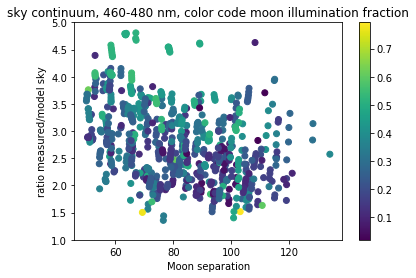

In [26]:
plt.scatter(bossdata['MOON_SEP'][imoon],skyratio[imoon],c=bossdata['MOON_ILL'][imoon])
plt.ylim(1,5)
plt.ylabel('ratio measured/model sky')
plt.xlabel('Moon separation')
plt.title('sky continuum, 460-480 nm, color code moon illumination fraction')
plt.colorbar()

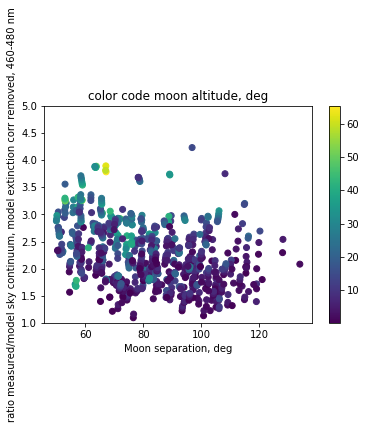

In [27]:
plt.scatter(bossdata['MOON_SEP'][imoon],extskyratio[imoon],c=bossdata['MOON_ALT'][imoon])
plt.ylim(1,5)
plt.ylabel('ratio measured/model sky continuum, model extinction corr removed, 460-480 nm')
plt.xlabel('Moon separation, deg')
plt.title('color code moon altitude, deg')
plt.colorbar()

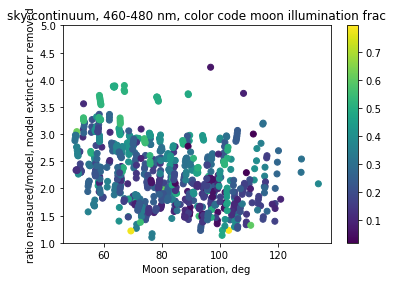

In [28]:
plt.scatter(bossdata['MOON_SEP'][imoon],extskyratio[imoon],c=bossdata['MOON_ILL'][imoon])
plt.ylim(1,5)
plt.ylabel('ratio measured/model, model extinct corr removed')
plt.xlabel('Moon separation, deg')
plt.title('sky continuum, 460-480 nm, color code moon illumination frac')
plt.colorbar()

In [29]:
def noll12moon(obs_zenith, moon_zenith, separation_angle, moon_phase,
                        vband_extinction):
    abs_alpha = 180. * moon_phase
    phi = 180.-abs_alpha
    m = -12.73 + 0.026 * abs_alpha + 4e-9 * abs_alpha ** 4
    # Calculate the illuminance of the moon outside the atmosphere in
    # foot-candles (eqn. 8).
    Istar = 10 ** (-0.4 * (m + 16.57))
    # Calculate the scattering airmass along the lines of sight to the
    # observation and moon (eqn. 3).
    X_obs = (1 - 0.96 * np.sin(obs_zenith) ** 2) ** (-0.5)
    X_moon = (1 - 0.96 * np.sin(moon_zenith) ** 2) ** (-0.5)
    # scattering functions
    rho = separation_angle.to(u.deg).value
    frac_rayleigh = (10**5.7)*(1.06+np.cos(separation_angle)**2)
    frac_mie = 10**(7.15-rho/40.)
    B_moon = ((frac_rayleigh+frac_mie) * Istar *
        10 ** (-0.4 * vband_extinction * X_moon) *
        (1 - 10 ** (-0.4 * (vband_extinction * X_obs))))
    # Convert from nanoLamberts to to mag / arcsec**2 using eqn.19 of
    # Garstang, "Model for Artificial Night-Sky Illumination",
    # PASP, vol. 98, Mar. 1986, p. 364 (http://dx.doi.org/10.1086/131768)
    return ((20.7233 - np.log(B_moon / 34.08)) / 0.92104 *
            u.mag / (u.arcsec ** 2))


In [30]:
# now call noll2moon
# cmodel is  DESI simulator, fully initialized
def getnoll12moon(cmodel):
    import astropy.units as u
    moon_zen = cmodel.atmosphere.moon.moon_zenith
    obs_zen = cmodel.atmosphere.obs_zenith
    airmass = cmodel.atmosphere.airmass
    moonsep = cmodel.atmosphere.moon.separation_angle
    moonphase = cmodel.atmosphere.moon.moon_phase 
    vbandext = cmodel.atmosphere.moon.vband_extinction
    moonspec = cmodel.atmosphere.moon._moon_spectrum
    wavelength = cmodel.atmosphere.moon._wavelength
    extcoeff = cmodel.atmosphere._extinction_coefficient
    scatteredmoonv = noll12moon(obs_zen,moon_zen,moonsep,moonphase,vbandext)
    # the astropy units take care of the conversion to radians: very cool!
    scat_airmass = (1.-0.96*np.sin(moon_zen)**2)**(-0.5)
    extinction = 10 **(-extcoeff*scat_airmass/2.5)*(1-10**(-extcoeff*airmass/2.5))
    moon_sb = moonspec*extinction
    rawvmag = cmodel.atmosphere.moon._vband.get_ab_magnitude(moon_sb,wavelength)*u.mag
    area = 1 * u.arcsec ** 2
    moon_sb *= 10 ** (-(scatteredmoonv * area - rawvmag) / (2.5 * u.mag)) /area
    return moon_sb

In [55]:
# wrapper to get model sky for the whole array, using the new model
# also implement David K's fix to the dark sky estimate to include a factor of the airmass
def getnoll12mooncont(bossdata):
    import specsim.simulator
    import astropy.units as u
    sky_unit = 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom * u.arcsec**2)
    # initialize simulator
    simi=specsim.simulator.Simulator('desi')
    # get unextincted dark time sky spectrum
    skyspec = simi.atmosphere._surface_brightness_dict['dark'].copy()
    # get wavelength range for continuum measurement
    lower = 4600
    upper = 4800
    wave = simi.atmosphere.moon._wavelength.value
    idx, = np.where((wave > lower)& (wave < upper))
    # output vector
    skyout=np.zeros((len(bossdata)))
    for i in range(len(bossdata)):
        simi.atmosphere.moon.moon_phase = bossdata['MPHASE'][i]
        simi.atmosphere.airmass = bossdata['AIRMASS'][i]
        simi.atmosphere.moon.moon_zenith=bossdata['MOON_ZENITH'][i]*u.deg
        simi.atmosphere.obs_zenith=bossdata['OBS_ZENITH'][i]*u.deg
        simi.atmosphere.moon.separation_angle=bossdata['MOON_SEP'][i]*u.deg  
        newmoon = getnoll12moon(simi)
        thisskyspec = simi.atmosphere.extinction*skyspec*(bossdata['AIRMASS'][i])
        allsky = newmoon + thisskyspec 
        skyout[i] = np.mean(allsky[idx].value)
    return skyout

In [56]:
esomodelsky = getnoll12mooncont(bossdata)

In [57]:
extesoskyratio = unextcont/(esomodelsky/sky_unit)

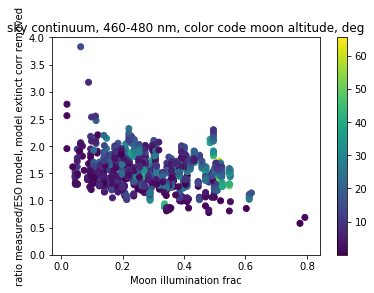

In [58]:
plt.scatter(bossdata['MOON_ILL'][imoon],extesoskyratio[imoon],c=bossdata['MOON_ALT'][imoon])
plt.ylim(0,4)
plt.ylabel('ratio measured/ESO model, model extinct corr removed')
plt.xlabel('Moon illumination frac')
plt.title('sky continuum, 460-480 nm, color code moon altitude, deg')
plt.colorbar()

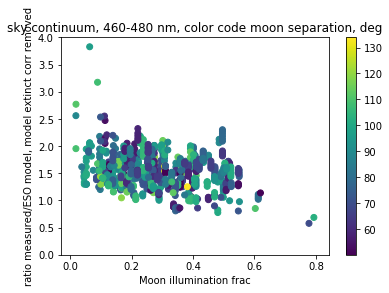

In [59]:
plt.scatter(bossdata['MOON_ILL'][imoon],extesoskyratio[imoon],c=bossdata['MOON_SEP'][imoon])
plt.ylim(0,4)
plt.ylabel('ratio measured/ESO model, model extinct corr removed')
plt.xlabel('Moon illumination frac')
plt.title('sky continuum, 460-480 nm, color code moon separation, deg')
plt.colorbar()

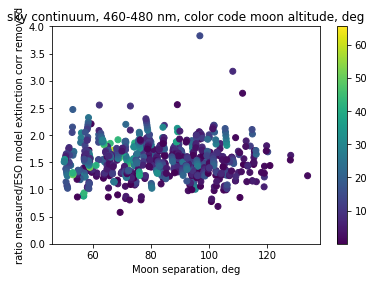

In [60]:
plt.scatter(bossdata['MOON_SEP'][imoon],extesoskyratio[imoon],c=bossdata['MOON_ALT'][imoon])
plt.ylim(0,4)
plt.ylabel('ratio measured/ESO model extinction corr removed')
plt.xlabel('Moon separation, deg')
plt.title('sky continuum, 460-480 nm, color code moon altitude, deg')
plt.colorbar()

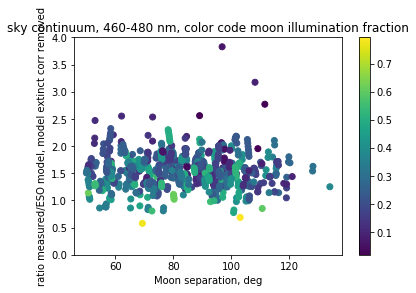

In [61]:
plt.scatter(bossdata['MOON_SEP'][imoon],extesoskyratio[imoon],c=bossdata['MOON_ILL'][imoon])
plt.ylim(0,4)
plt.ylabel('ratio measured/ESO model, model extinct corr removed')
plt.xlabel('Moon separation, deg')
plt.title('sky continuum, 460-480 nm, color code moon illumination fraction')
plt.colorbar()

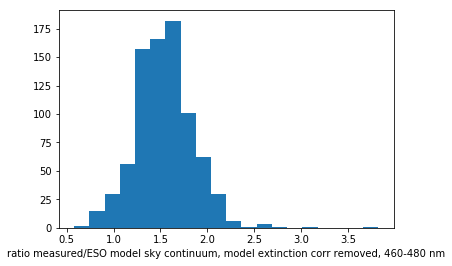

In [62]:
a,b,c = plt.hist(extesoskyratio[imoon],bins=20)
plt.xlabel('ratio measured/ESO model sky continuum, model extinction corr removed, 460-480 nm')

In [63]:
np.mean(extesoskyratio[imoon])

<Quantity 1.5428406221654776 erg / (Angstrom arcsec2 cm2 s)>

In [64]:
np.std(extesoskyratio[imoon])

<Quantity 0.3147097905813456 erg / (Angstrom arcsec2 cm2 s)>

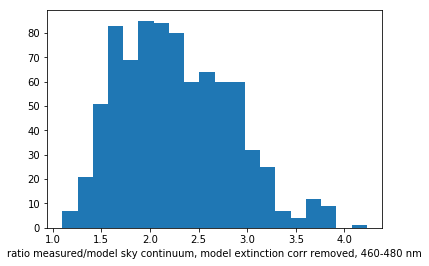

In [65]:
a,b,c = plt.hist(extskyratio[imoon],bins=20)
plt.xlabel('ratio measured/model sky continuum, model extinction corr removed, 460-480 nm')

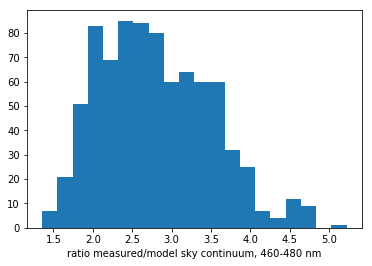

In [66]:
a,b,c = plt.hist(skyratio[imoon],bins=20)
plt.xlabel('ratio measured/model sky continuum, 460-480 nm')

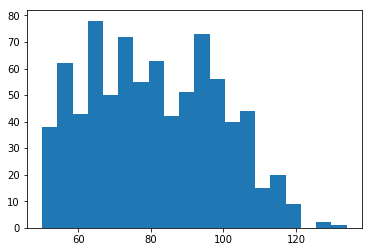

In [67]:
a,b,c = plt.hist(bossdata['MOON_SEP'][imoon],bins=20)

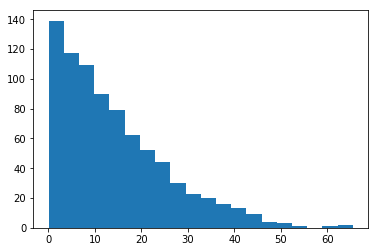

In [68]:
a,b,c = plt.hist(bossdata['MOON_ALT'][imoon],bins=20)

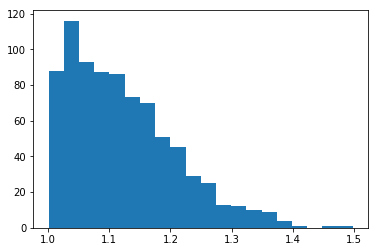

In [69]:
a,b,c = plt.hist(bossdata['AIRMASS'][imoon],bins=20)

In [70]:
np.std(extesoskyratio[imoon])

<Quantity 0.3147097905813456 erg / (Angstrom arcsec2 cm2 s)>

In [71]:
esoskyratio = bossdata['SKY_VALUE']/(esomodelsky/sky_unit)

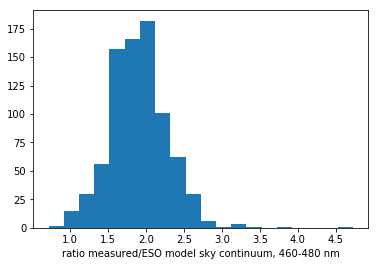

In [72]:
a,b,c = plt.hist(esoskyratio[imoon],bins=20)
plt.xlabel('ratio measured/ESO model sky continuum, 460-480 nm')

In [73]:
np.mean(esoskyratio[imoon])

<Quantity 1.904818814989322 erg / (Angstrom arcsec2 cm2 s)>

In [74]:
np.std(esoskyratio[imoon])

<Quantity 0.3885463746211893 erg / (Angstrom arcsec2 cm2 s)>

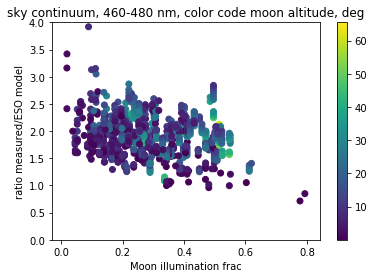

In [75]:
plt.scatter(bossdata['MOON_ILL'][imoon],esoskyratio[imoon],c=bossdata['MOON_ALT'][imoon])
plt.ylim(0,4)
plt.ylabel('ratio measured/ESO model')
plt.xlabel('Moon illumination frac')
plt.title('sky continuum, 460-480 nm, color code moon altitude, deg')
plt.colorbar()

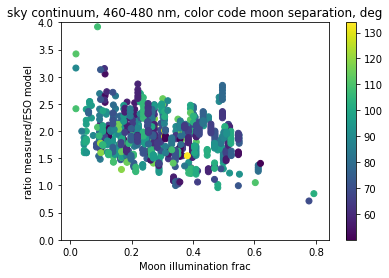

In [76]:
plt.scatter(bossdata['MOON_ILL'][imoon],esoskyratio[imoon],c=bossdata['MOON_SEP'][imoon])
plt.ylim(0,4)
plt.ylabel('ratio measured/ESO model')
plt.xlabel('Moon illumination frac')
plt.title('sky continuum, 460-480 nm, color code moon separation, deg')
plt.colorbar()

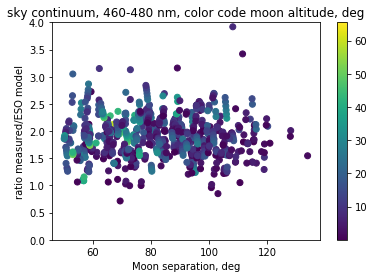

In [77]:
plt.scatter(bossdata['MOON_SEP'][imoon],esoskyratio[imoon],c=bossdata['MOON_ALT'][imoon])
plt.ylim(0,4)
plt.ylabel('ratio measured/ESO model')
plt.xlabel('Moon separation, deg')
plt.title('sky continuum, 460-480 nm, color code moon altitude, deg')
plt.colorbar()

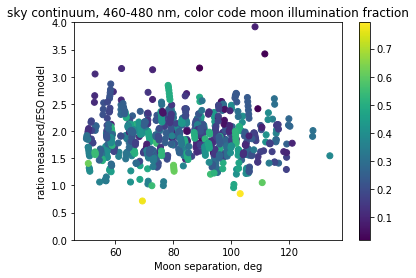

In [78]:
plt.scatter(bossdata['MOON_SEP'][imoon],esoskyratio[imoon],c=bossdata['MOON_ILL'][imoon])
plt.ylim(0,4)
plt.ylabel('ratio measured/ESO model')
plt.xlabel('Moon separation, deg')
plt.title('sky continuum, 460-480 nm, color code moon illumination fraction')
plt.colorbar()

In [79]:
idark, = np.where(bossdata['MOON_ALT'] < -10)

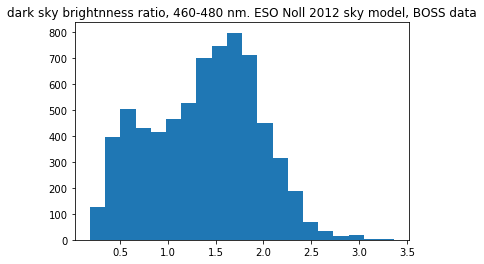

In [87]:
a,b,c = plt.hist(esoskyratio[idark],bins=20)
plt.title('dark sky brightnness ratio, 460-480 nm. ESO Noll 2012 sky model, BOSS data')

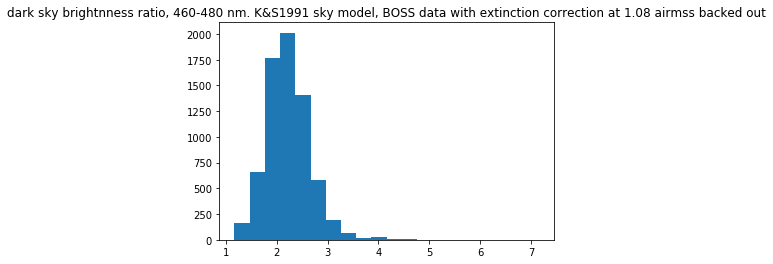

In [88]:
a,b,c = plt.hist(skyratio[idark],bins=20)
plt.title('dark sky brightnness ratio, 460-480 nm. K&S1991 sky model, BOSS data with extinction correction at 1.08 airmss backed out')